Final Dataset with Play Styles and Encoded Labels:    avg_ball_control  avg_boost_usage  shots_on_goal  saves    file_name  \
0          0.500000        27.137755              0      0  115445.json   
1          0.498195        34.462094              2      0  115446.json   
2          0.500000        24.011299              8      0  115486.json   
3          0.498471        18.314985              6      0  115487.json   
4          0.500000        29.027778              0      0  116125.json   

   play_style  
0      Hybrid  
1      Hybrid  
2  Aggressive  
3      Hybrid  
4      Hybrid  
Results saved to Excel at Data/final_dataset.xlsx


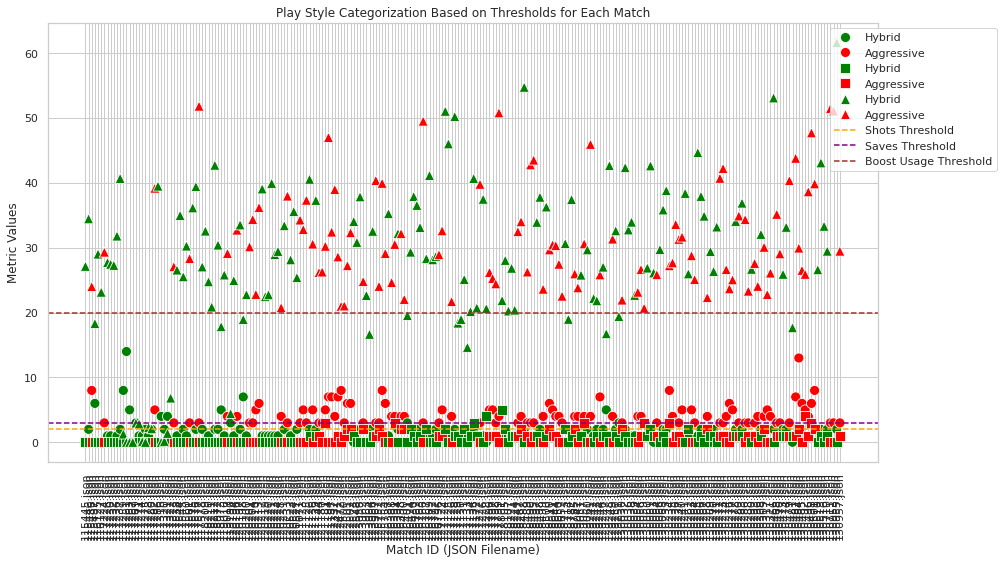

In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
json_dir = "Data"
SHOTS_THRESHOLD = 2
SAVES_THRESHOLD = 3
BOOST_USAGE_THRESHOLD = 20
palette = {"Aggressive": "red", "Defensive": "blue", "Hybrid": "green"}

def preprocess_game_data(data):
    frame_data = data.get('rounds', {}).get('0', {}).get('clock', [])
    ball_control_data = data.get('rounds', {}).get('0', {}).get('ball_control', [])
    boost_usage_data = data.get('rounds', {}).get('0', {}).get('boost_value', [])
    shots_on_goal_data = data.get('rounds', {}).get('0', {}).get('shots_on_goal', [])
    saves_data = data.get('rounds', {}).get('0', {}).get('saves', [])

    max_length = max(len(frame_data), len(ball_control_data), len(boost_usage_data), len(shots_on_goal_data), len(saves_data))

    def adjust_length(lst, fill_value):
        return lst + [fill_value] * (max_length - len(lst)) if len(lst) < max_length else lst

    frame_data = adjust_length(frame_data, [0, '0:00'])
    ball_control_data = adjust_length(ball_control_data, [0, False])
    boost_usage_data = adjust_length(boost_usage_data, [0, 0])
    shots_on_goal_data = adjust_length(shots_on_goal_data, [0, False])
    saves_data = adjust_length(saves_data, [0, False])

    df = pd.DataFrame({
        'frame': [f[0] for f in frame_data],
        'ball_control': [bc[1] for bc in ball_control_data],
        'boost_value': [b[1] for b in boost_usage_data],
        'shots_on_goal': [s[1] for s in shots_on_goal_data],
        'saves': [s[1] for s in saves_data]
    })

    features = {
        'avg_ball_control': np.mean(df['ball_control']),
        'avg_boost_usage': np.mean(df['boost_value']),
        'shots_on_goal': df['shots_on_goal'].sum(),
        'saves': df['saves'].sum(),
        'file_name': filename
    }

    if features['shots_on_goal'] > SHOTS_THRESHOLD and features['avg_boost_usage'] > BOOST_USAGE_THRESHOLD:
        features['play_style'] = 'Aggressive'
    elif features['saves'] > SAVES_THRESHOLD and features['avg_boost_usage'] < BOOST_USAGE_THRESHOLD:
        features['play_style'] = 'Defensive'
    else:
        features['play_style'] = 'Hybrid'

    return features

feature_datasets = []

for filename in os.listdir(json_dir):
    if filename.endswith(".json"):
        filepath = os.path.join(json_dir, filename)
        with open(filepath, 'r') as file:
            data = json.load(file)
            data=data.get('statistics',[None])[0]
            if data is None:
                continue
            features = preprocess_game_data(data)
            feature_datasets.append(features)

final_dataset = pd.DataFrame(feature_datasets)
print("Final Dataset with Play Styles and Encoded Labels:", final_dataset.head())
# Save as Excel
excel_output_path = os.path.join("Data", "final_dataset.xlsx")
final_dataset.to_excel(excel_output_path, index=False)
print(f"Results saved to Excel at {excel_output_path}")
plot_dir = "Images"
os.makedirs(plot_dir, exist_ok=True)

# Filename for the plot image
plot_filename = os.path.join(plot_dir, "play_style_categorization_plot.png")

plt.figure(figsize=(14, 8))
sns.scatterplot(
    x=final_dataset['file_name'],
    y=final_dataset['shots_on_goal'],
    hue=final_dataset['play_style'],
    palette=palette,
    s=100
)

sns.scatterplot(
    x=final_dataset['file_name'],
    y=final_dataset['saves'],
    hue=final_dataset['play_style'],
    palette=palette,
    s=100,
    marker='s'
)

sns.scatterplot(
    x=final_dataset['file_name'],
    y=final_dataset['avg_boost_usage'],
    hue=final_dataset['play_style'],
    palette=palette,
    s=100,
    marker='^'
)

plt.axhline(SHOTS_THRESHOLD, color="orange", linestyle="--", label="Shots Threshold")
plt.axhline(SAVES_THRESHOLD, color="purple", linestyle="--", label="Saves Threshold")
plt.axhline(BOOST_USAGE_THRESHOLD, color="brown", linestyle="--", label="Boost Usage Threshold")

plt.xlabel("Match ID (JSON Filename)")
plt.ylabel("Metric Values")
plt.title("Play Style Categorization Based on Thresholds for Each Match")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))

plt.xticks(rotation=90)
plt.tight_layout()

# Save the plot
plt.savefig(plot_filename, format='png', dpi=300)

plt.show()

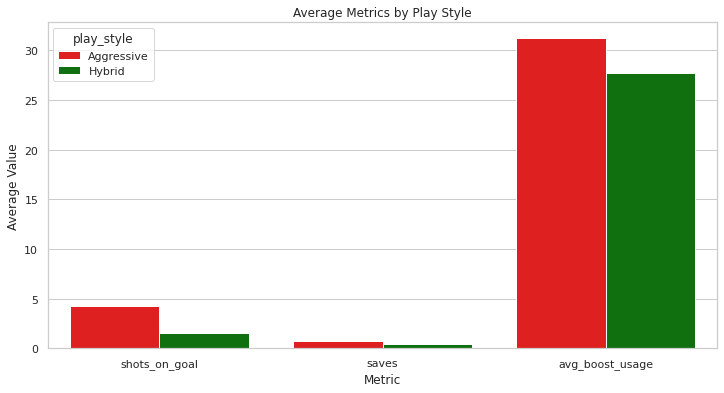

In [2]:

#Bar Plot for Average Metric Comparison

avg_metrics = final_dataset.groupby('play_style').mean()[['shots_on_goal', 'saves', 'avg_boost_usage']].reset_index()
avg_metrics_melted = avg_metrics.melt(id_vars='play_style', var_name='Metric', value_name='Average Value')
# Filename for the plot image
plot_filename = os.path.join(plot_dir, "Boost_Save_Shots.png")
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Average Value', hue='play_style', data=avg_metrics_melted, palette=palette)
plt.title("Average Metrics by Play Style")
plt.xlabel("Metric")
plt.ylabel("Average Value")
# Save the plot
plt.savefig(plot_filename, format='png', dpi=300) 
plt.show()


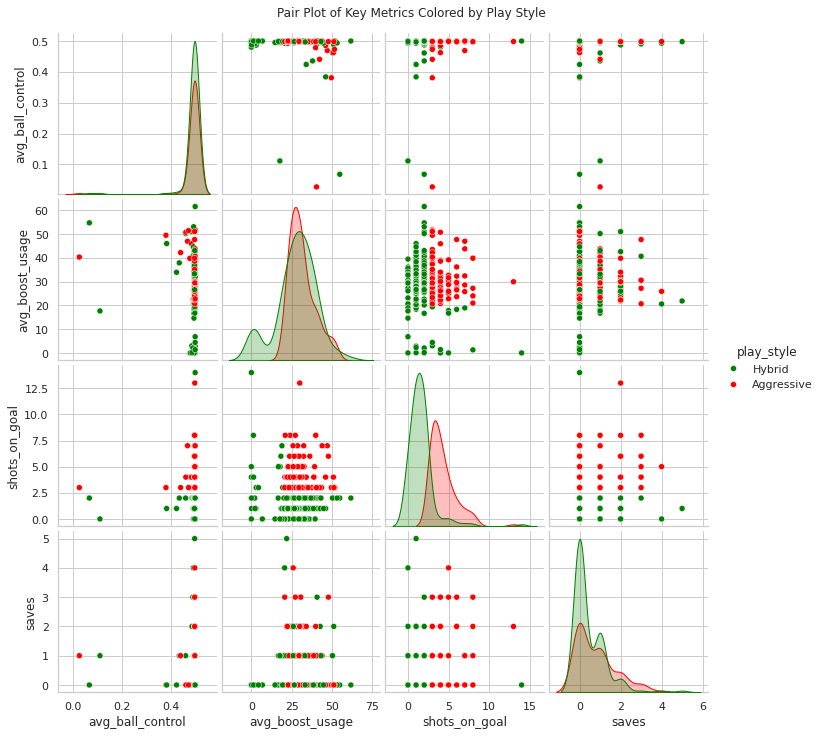

In [3]:

#Pair-Plot for feature relationships
# Filename for the plot image
plot_filename = os.path.join(plot_dir, "Pair_Plot_Boost_Save_Shots.png")
sns.pairplot(final_dataset, hue='play_style', palette=palette, diag_kind='kde')
plt.suptitle("Pair Plot of Key Metrics Colored by Play Style", y=1.02)
plt.savefig(plot_filename, format='png', dpi=300) 
plt.show()


Final Dataset with Play Styles:    avg_ball_control    file_name  play_style
0          0.500000  115445.json  Aggressive
1          0.498195  115446.json   Defensive
2          0.500000  115486.json  Aggressive
3          0.498471  115487.json  Aggressive
4          0.500000  116125.json  Aggressive


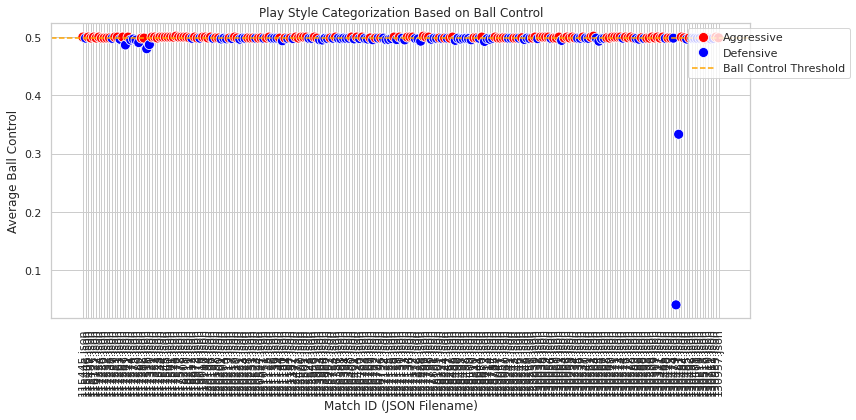

In [4]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plot style
sns.set(style="whitegrid")
json_dir = "Data"  
BALL_CONTROL_THRESHOLD = 0.4982  # Adjust this threshold as needed
palette = {"Aggressive": "red", "Defensive": "blue"}

def preprocess_game_data(data):
    # Extract relevant data for frames and ball control
    frames = data.get('rounds', {}).get('0', {}).get('clock', [])
    ball_control = data.get('rounds', {}).get('0', {}).get('ball_control', [])
    
    # Ensure both lists have the same length
    max_length = max(len(frames), len(ball_control))
    
    def adjust_length(lst, fill_value):
        return lst + [fill_value] * (max_length - len(lst)) if len(lst) < max_length else lst
    
    frames = adjust_length(frames, [0, '0:00'])
    ball_control = adjust_length(ball_control, [0, False])
    
    # Create DataFrame with ball control data
    df = pd.DataFrame({
        'frame': [f[0] for f in frames],
        'ball_control': [bc[1] for bc in ball_control]
    })
    return df

# List to store feature data
feature_datasets = []

# Process each JSON file in the directory
for filename in os.listdir(json_dir):
    if filename.endswith(".json"):
        filepath = os.path.join(json_dir, filename)
        with open(filepath, 'r') as file:
            data = json.load(file)
            data=data.get('statistics',[None])[0]
            if data is None:
                continue
            processed_data = preprocess_game_data(data)
            #print(f"Processed Data for {filename}:", processed_data.head())
            
            # Calculate average ball control
            features = {
                'avg_ball_control': np.mean(processed_data['ball_control']),
                'file_name': filename
            }
            
            # Determine play style based on ball control threshold
            if features['avg_ball_control'] > BALL_CONTROL_THRESHOLD:
                features['play_style'] = 'Aggressive'
            else:
                features['play_style'] = 'Defensive'
            
            feature_datasets.append(features)

# Create a DataFrame with results
final_dataset = pd.DataFrame(feature_datasets)
print("Final Dataset with Play Styles:", final_dataset.head())
# Filename for the plot image
plot_filename = os.path.join(plot_dir, "Ball_control_plot.png")
# Plot the results
plt.figure(figsize=(12, 6))

sns.scatterplot(
    x=final_dataset['file_name'],
    y=final_dataset['avg_ball_control'],
    hue=final_dataset['play_style'],
    palette=palette,
    s=100
)

# Add threshold line
plt.axhline(BALL_CONTROL_THRESHOLD, color="orange", linestyle="--", label="Ball Control Threshold")

plt.xlabel("Match ID (JSON Filename)")
plt.ylabel("Average Ball Control")
plt.title("Play Style Categorization Based on Ball Control")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))

plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(plot_filename, format='png', dpi=300)
plt.show()


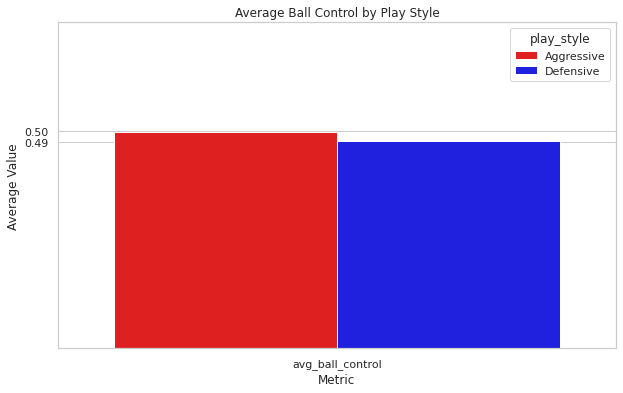

In [5]:
# Bar Plot for Average Ball Control by Play Style

# Calculate the average ball control for each play style
avg_metrics = final_dataset.groupby('play_style').mean()[['avg_ball_control']].reset_index()
avg_metrics_melted = avg_metrics.melt(id_vars='play_style', var_name='Metric', value_name='Average Value')
# Filename for the plot image
plot_filename = os.path.join(plot_dir, "Ball_control_bar_plot.png")
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Average Value', hue='play_style', data=avg_metrics_melted, palette=palette)
plt.title("Average Ball Control by Play Style")
plt.xlabel("Metric")
plt.ylabel("Average Value")

# Set x-axis limits and ticks to only display 0.4 and 0.5
plt.ylim(0.3, 0.6)
plt.yticks([0.49, 0.5])
plt.savefig(plot_filename, format='png', dpi=300)
plt.show()


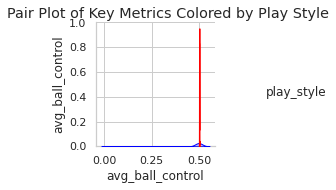

In [6]:

#Pair-Plot for feature relationships
# Filename for the plot image
plot_filename = os.path.join(plot_dir, "Ball_control_pair_plot.png")
sns.pairplot(final_dataset, hue='play_style', palette=palette, diag_kind='kde')
plt.suptitle("Pair Plot of Key Metrics Colored by Play Style", y=1.02)
plt.savefig(plot_filename, format='png', dpi=300)
plt.show()
